In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
df_log = pd.read_csv('VisitorLogsData.csv')

print(df_log.shape)

(6588000, 9)


In [3]:
df_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6588000 entries, 0 to 6587999
Data columns (total 9 columns):
webClientID      object
VisitDateTime    object
ProductID        object
UserID           object
Activity         object
Browser          object
OS               object
City             object
Country          object
dtypes: object(9)
memory usage: 452.4+ MB


In [4]:
df_user = pd.read_csv('userTable.csv')

In [5]:
df_user.shape

(34050, 3)

## lets merge the tables on userid to get consolidated data

In [6]:
df_final = pd.merge(df_log,df_user,on='UserID',how='inner')
df_final['ProductID'] = df_final['ProductID'].apply(lambda x: str(x).capitalize())
df_final['Activity'] = df_final['Activity'].apply(lambda x: str(x).lower())
print(df_final)

           webClientID            VisitDateTime ProductID   UserID  Activity  \
0       WI100000112772      1526366895249000000  Pr100017  U106593     click   
1       WI100000112772  2018-05-16 06:53:23.737  Pr100241  U106593  pageload   
2       WI100000112772  2018-05-15 06:47:49.239  Pr100017  U106593     click   
3       WI100000112772  2018-05-16 06:54:26.424  Pr100901  U106593  pageload   
4       WI100000112772  2018-05-15 06:47:36.691  Pr100017  U106593     click   
...                ...                      ...       ...      ...       ...   
650690  WI100000977958  2018-05-19 12:51:25.121  Pr100083  U121518  pageload   
650691  WI100000696937  2018-05-21 06:49:59.537  Pr100102  U119259  pageload   
650692  WI100000949074  2018-05-14 22:27:00.115  Pr100294  U127061     click   
650693  WI100000949074  2018-05-14 22:27:00.115  Pr100294  U127061     click   
650694  WI100000320335  2018-05-18 12:06:27.537  Pr100017  U122948       nan   

              Browser        OS       C

### clean the dates

In [7]:
#### COnvert date time to python pandas format




########################## This function is applied to get the dates #####################################################
#
#                     Using the below function to get friendly format date
#
##########################################################################################################################
def formatdate(date):
    try:
        date = np.int64(date)
        date = pd.to_datetime(date)
    except(ValueError):
        date = pd.to_datetime(date)
    return date    
####################################### Function Ends  ########################################################################


df_final['VisitDateTime'] = df_final['VisitDateTime'].apply(formatdate)
    

In [8]:
df_final['VisitDateTime'].isnull().sum()

64803

### The user has to atleast open webite before he/she clicks

In [9]:
#df_final_model = df_final[~df_final['VisitDateTime'].isnull()]
df_final_model = df_final
df_final_model['Activity'] = df_final_model['Activity'].fillna("pageload")


#df_final_model['Activity'] = df_final_model['Activity'].apply(lambda x: "pageload" if x.lower() == 'nan' else x)

###  Now let us create a column for date only

### Let us now get the Features from the data

- We will have to do group by operations
- Groupby requires aggregate functions
- Then we will do the concatenation part for the dataframe


#### Let us do the first group by no of days visited in past `7` days

In [10]:
today = pd.to_datetime("28-May-2018") 
startdate = today+ pd.Timedelta(-7,'D')
startdate
df_final_model['HasVisited'] = df_final_model['VisitDateTime'].apply(lambda x: x >= startdate)

In [11]:
df_final_model['VisitedDate'] = df_final_model['VisitDateTime'].apply(lambda x: x.date())

df_testsample = df_final_model[['UserID','VisitedDate','HasVisited']].drop_duplicates()
df_testsample[~df_testsample['VisitedDate'].isnull()].sum()

UserID        U106593U106593U106593U106593U106593U106593U108...
HasVisited                                                25636
dtype: object

### Let us do the groupby 

In [12]:

df_visited = df_testsample.loc[:,['UserID','HasVisited']]

df_feature_one = df_visited.groupby(by='UserID').sum()

df_feature_one

,HasVisited
UserID,
U100002,0.0
U100003,1.0
U100004,1.0
U100005,1.0
U100006,1.0
...,...
U136960,0.0
U136961,0.0
U136963,0.0


#### Creating a function which groups by respective columns and finds the count

In [13]:
df_final_model = df_final_model.drop('HasVisited',axis=1)

def group_users(by,no_of_days,df=df_final_model,today=today):
    
    startdate = today + pd.Timedelta(-1*no_of_days,'D')
    
    df['Has'+ by] = df['VisitDateTime'].apply(lambda x: x >= startdate)
    
    df_grouped = df.loc[:,['UserID','ProductID','Has' + by]].drop_duplicates()
    
    df_grouped = df_grouped.groupby(by='UserID').sum()
    
    df = df.drop('Has' + by, axis=1)
    
    return df_grouped

In [14]:
product_15days = group_users('ProductID',15)
product_15days

,HasProductID
UserID,
U100002,2.0
U100003,3.0
U100004,16.0
U100005,3.0
U100006,1.0
...,...
U136960,0.0
U136961,0.0
U136963,0.0


### Finding the vintage of the user
- The vintage the the no of days since when the user registered till today.
- we will create a data frame

In [15]:
import re

df_vintage = df_user.loc[:,['UserID','Signup Date']]
df_vintage['Signup Date'] = df_vintage['Signup Date'].apply(lambda x: pd.to_datetime(x))


df_vintage['Vintage'] = df_vintage['Signup Date'].apply(lambda x: today.date() - x.date())
df_vintage['Vintage'] = df_vintage['Vintage'].apply(lambda x: str(x))
df_vintage['Vintage'] = df_vintage['Vintage'].apply(lambda x: int(re.search("^\d+",x).group()))


df_vintage = df_vintage.drop('Signup Date',axis=1)
df_vintage

,UserID,Vintage
0,U133159,44
1,U129368,177
2,U109654,1896
3,U108998,130
4,U131393,62
...,...,...
34045,U134073,70
34046,U113667,89
34047,U128470,85
34048,U104005,126


### Get Most viewed products in 15 days

1. Here the mode will be the aggregate function 

In [16]:

def date_diff(startdate,end=today,df=df_final_model):
    dtx = today - pd.Timedelta(15,'D')
    try:
        if dtx.date() >= startdate.date() and df['Action'] == 'pageload':
            res = True
        else:
            res = False
        
    except:
        res = False
        
    return res
    


df_final_model['HasViewedProduct'] = df_final_model['VisitDateTime'].apply(date_diff)
#df_final_model.groupby(by=['UserID','ProductID']).count()



In [17]:
df_mostviewedproduct = df_final_model.groupby(by=['UserID','ProductID']).count()

In [18]:
users = df_user['UserID'].unique()

df_mostviewedproduct.index

MultiIndex([('U100002', 'Pr100258'),
            ('U100002', 'Pr101097'),
            ('U100003',      'Nan'),
            ('U100003', 'Pr100079'),
            ('U100003', 'Pr100178'),
            ('U100004',      'Nan'),
            ('U100004', 'Pr100005'),
            ('U100004', 'Pr100069'),
            ('U100004', 'Pr100142'),
            ('U100004', 'Pr100197'),
            ...
            ('U136959', 'Pr100551'),
            ('U136959', 'Pr100656'),
            ('U136960', 'Pr100172'),
            ('U136961', 'Pr101381'),
            ('U136963',      'Nan'),
            ('U136963', 'Pr100102'),
            ('U136963', 'Pr100166'),
            ('U136963', 'Pr100254'),
            ('U136964', 'Pr100769'),
            ('U136965', 'Pr100709')],
           names=['UserID', 'ProductID'], length=127341)

### Lets do the group by activity

In [19]:
df_mostviewedproduct = df_final_model.groupby(by=['UserID']).agg({"ProductID":lambda x: x.value_counts().index[0]})

In [20]:
df_mostviewedproduct['ProductID'] = df_mostviewedproduct['ProductID'].apply(lambda x: x if x != 'Nan' else 'Product101')

In [21]:
df_mostviewedproduct = df_mostviewedproduct.rename(columns={'ProductID':'MostViewed'})
print(df_mostviewedproduct)

         MostViewed
UserID             
U100002    Pr100258
U100003    Pr100079
U100004  Product101
U100005    Pr100812
U100006    Pr101111
...             ...
U136960    Pr100172
U136961    Pr101381
U136963    Pr100102
U136964    Pr100769
U136965    Pr100709

[34050 rows x 1 columns]


#### Now lets do most active os

In [22]:
df_active_os = df_final_model.groupby(by=['UserID']).agg({"OS":lambda x: x.value_counts().index[0]})
df_active_os['OS']=df_active_os['OS'].apply(lambda x :x.lower())
df_active_os

,OS
UserID,
U100002,android
U100003,windows
U100004,windows
U100005,android
U100006,android
...,...
U136960,windows
U136961,android
U136963,android


### Lets work on recently viewed product 

In [23]:
# df_recent_product  = df_final_model[['UserID',"VisitDateTime"]].groupby(by="UserID").max()
# df_recent_product.shape


In [24]:
# df_recent_product = pd.merge(df_recent_product,df_final_model,on=['UserID','VisitDateTime'],how='inner')
# df_recent_product = df_recent_product[["UserID","ProductID","Activity",'VisitDateTime']].drop_duplicates()
# print(df_recent_product.shape)

# ### If visit date and Time is invalid then make the Product as Product101
# df_recent_product.loc[df_recent_product['VisitDateTime'].isnull(),'ProductID'] = 'Product101'

# ### Users that have loaded the pages.



# df_recent_product_one = df_recent_product[df_recent_product["Activity"] == 'pageload']


# temp_df = df_recent_product[~(df_recent_product["UserID"].isin(df_recent_product_one["UserID"].unique()))]
# temp_df['ProductID'] = 'Product101'


# #df_recent_product = df_recent_product[df_recent_product["Activity"] != 'pageload'].drop_duplicates()
# pd.concat([df_recent_product_one,temp_df])#

In [25]:
# df_recent_product = pd.concat([df_recent_product_one,temp_df]).drop_duplicates()


# df_recent_product["Activity"] = df_recent_product["Activity"].apply(lambda x: "invalid" if x!='pageload' else x)
# df_recent_product["ProductID"] = df_recent_product["ProductID"].apply(lambda a: a if a.lower() != 'nan' else 'Product101')
# #df_recent_product["ProductID"] = 
# df_recent_product = df_recent_product.sort_values(by='UserID')[["UserID","ProductID"]].drop_duplicates()

In [26]:
# df_recent_product[df_recent_product['UserID'] == 'U106330']

# #df_final_model[df_final_model['UserID'] == 'U106330']
# df_recent_product.shape

### Imputing pageloads 7 days

In [27]:
def group_users_activity(by,no_of_days,activity,df=df_final_model,today=today):
    
    startdate = today + pd.Timedelta(-1*no_of_days,'D')
    
    
    
    
    df['IsActivity'] = (df[by] == activity)
    #print(df['IsActivity'])
    df['Has'+ activity] = (df['VisitDateTime'] >= startdate) & df['IsActivity']
    
     #print(df['Has'+ activity])
    
    df_grouped = df.loc[:,['UserID','Has' + activity]]
    
    df_grouped = df_grouped.groupby(by='UserID').sum()
    
    df = df.drop('Has' + activity, axis=1)
    
    return df_grouped

In [28]:
df_pageLoads = group_users_activity('Activity',7,'pageload')
df_pageLoads

,Haspageload
UserID,
U100002,0.0
U100003,1.0
U100004,1.0
U100005,1.0
U100006,1.0
...,...
U136960,0.0
U136961,0.0
U136963,0.0


### Imputing clicks 7 days

In [29]:
df_click = group_users_activity('Activity',7,'click')
df_click

,Hasclick
UserID,
U100002,0.0
U100003,2.0
U100004,0.0
U100005,0.0
U100006,0.0
...,...
U136960,0.0
U136961,0.0
U136963,0.0


### Let us find most recently product by user

In [30]:
df_recent_product = df_final_model.groupby(by='UserID')[['VisitDateTime','Haspageload']].max()

In [31]:
df_recent_product['UserID'] = df_recent_product.index
df_recent_product.index.rename('Garbage',inplace=True)

In [32]:
df_recent_product = pd.merge(df_recent_product,df_final_model[['UserID','VisitDateTime','ProductID']],on=['VisitDateTime','UserID'])

In [33]:
df_recent_product = df_recent_product.drop_duplicates()

df_recent_product.loc[df_recent_product['VisitDateTime'].isnull(),'ProductID'] = 'Product101'

df_recent_product = df_recent_product.drop_duplicates()

In [34]:
df_recent_product = df_recent_product.drop(['VisitDateTime','Haspageload'],axis=1)

### Concatinate all results

In [35]:
ans = pd.concat([df_feature_one,product_15days],axis=1)#,df_active_os,df_recent_product,df_pageLoads,df_click],axis=1)

In [36]:
ans

,HasVisited,HasProductID
UserID,,
U100002,0.0,2.0
U100003,1.0,3.0
U100004,1.0,16.0
U100005,1.0,3.0
U100006,1.0,1.0
...,...,...
U136960,0.0,0.0
U136961,0.0,0.0
U136963,0.0,0.0


In [37]:
df_vintage = df_vintage.sort_values(by='UserID')

ans = pd.merge(df_vintage,ans,on='UserID')

In [38]:
ans = pd.merge(df_active_os,ans,on='UserID')
ans

,UserID,OS,Vintage,HasVisited,HasProductID
0,U100002,android,53,0.0,2.0
1,U100003,windows,1021,1.0,3.0
2,U100004,windows,341,1.0,16.0
3,U100005,android,681,1.0,3.0
4,U100006,android,55,1.0,1.0
...,...,...,...,...,...
34045,U136960,windows,755,0.0,0.0
34046,U136961,android,60,0.0,0.0
34047,U136963,android,1420,0.0,0.0
34048,U136964,windows,495,0.0,0.0


In [39]:
ans = pd.merge(df_recent_product,ans,on='UserID')
ans

,UserID,ProductID,OS,Vintage,HasVisited,HasProductID
0,U100002,Pr100258,android,53,0.0,2.0
1,U100003,Nan,windows,1021,1.0,3.0
2,U100004,Nan,windows,341,1.0,16.0
3,U100005,Pr100234,android,681,1.0,3.0
4,U100006,Pr101111,android,55,1.0,1.0
...,...,...,...,...,...,...
34045,U136960,Pr100172,windows,755,0.0,0.0
34046,U136961,Pr101381,android,60,0.0,0.0
34047,U136963,Pr100166,android,1420,0.0,0.0
34048,U136964,Pr100769,windows,495,0.0,0.0


In [40]:

ans = pd.merge(df_pageLoads,ans,on='UserID')
ans

,UserID,Haspageload,ProductID,OS,Vintage,HasVisited,HasProductID
0,U100002,0.0,Pr100258,android,53,0.0,2.0
1,U100003,1.0,Nan,windows,1021,1.0,3.0
2,U100004,1.0,Nan,windows,341,1.0,16.0
3,U100005,1.0,Pr100234,android,681,1.0,3.0
4,U100006,1.0,Pr101111,android,55,1.0,1.0
...,...,...,...,...,...,...,...
34045,U136960,0.0,Pr100172,windows,755,0.0,0.0
34046,U136961,0.0,Pr101381,android,60,0.0,0.0
34047,U136963,0.0,Pr100166,android,1420,0.0,0.0
34048,U136964,0.0,Pr100769,windows,495,0.0,0.0


In [41]:
ans = pd.merge(df_click,ans,on='UserID')
ans

,UserID,Hasclick,Haspageload,ProductID,OS,Vintage,HasVisited,HasProductID
0,U100002,0.0,0.0,Pr100258,android,53,0.0,2.0
1,U100003,2.0,1.0,Nan,windows,1021,1.0,3.0
2,U100004,0.0,1.0,Nan,windows,341,1.0,16.0
3,U100005,0.0,1.0,Pr100234,android,681,1.0,3.0
4,U100006,0.0,1.0,Pr101111,android,55,1.0,1.0
...,...,...,...,...,...,...,...,...
34045,U136960,0.0,0.0,Pr100172,windows,755,0.0,0.0
34046,U136961,0.0,0.0,Pr101381,android,60,0.0,0.0
34047,U136963,0.0,0.0,Pr100166,android,1420,0.0,0.0
34048,U136964,0.0,0.0,Pr100769,windows,495,0.0,0.0


In [42]:
ans = pd.merge(df_mostviewedproduct,ans,on='UserID')
ans

,UserID,MostViewed,Hasclick,Haspageload,ProductID,OS,Vintage,HasVisited,HasProductID
0,U100002,Pr100258,0.0,0.0,Pr100258,android,53,0.0,2.0
1,U100003,Pr100079,2.0,1.0,Nan,windows,1021,1.0,3.0
2,U100004,Product101,0.0,1.0,Nan,windows,341,1.0,16.0
3,U100005,Pr100812,0.0,1.0,Pr100234,android,681,1.0,3.0
4,U100006,Pr101111,0.0,1.0,Pr101111,android,55,1.0,1.0
...,...,...,...,...,...,...,...,...,...
34045,U136960,Pr100172,0.0,0.0,Pr100172,windows,755,0.0,0.0
34046,U136961,Pr101381,0.0,0.0,Pr101381,android,60,0.0,0.0
34047,U136963,Pr100102,0.0,0.0,Pr100166,android,1420,0.0,0.0
34048,U136964,Pr100769,0.0,0.0,Pr100769,windows,495,0.0,0.0


In [43]:
answer = ans.rename(columns = {
    'UserID': 'UserID',
    "HasVisited": 'No_of_days_Visited_7_Days',
                  'HasProductID':'No_Of_Products_Viewed_15_Days',
                   'Vintage':'User_Vintage',
                     "MostViewed": 'Most_Viewed_product_15_Days',
                    'OS': 'Most_Active_OS',
                    'ProductID':'Recently_Viewed_Product', 
                  'Haspageload': 'Pageloads_last_7_days',
                  'Hasclick':'Clicks_last_7_days'

                 },inplace=False)

In [44]:
answer['Recently_Viewed_Product'] = answer['Recently_Viewed_Product'].apply(lambda x: 'Product101' if x == 'Nan' else x)

In [45]:
answer = answer[['UserID', 'No_of_days_Visited_7_Days', 'No_Of_Products_Viewed_15_Days', 
                 'User_Vintage', 'Most_Viewed_product_15_Days', 
                  'Most_Active_OS',
'Recently_Viewed_Product', 'Pageloads_last_7_days', 'Clicks_last_7_days']]


answer.to_csv("First.csv",index=False)

In [46]:
df_final_model['Haspageload'].value_counts()

False    597197
True      53498
Name: Haspageload, dtype: int64

## Visuals section


### Let us find top 5 popular products

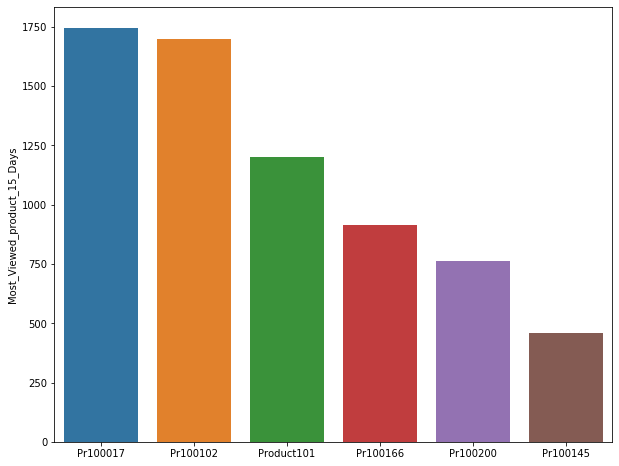

In [47]:
popular_products = answer['Most_Viewed_product_15_Days'].value_counts()[:6]

plt.figure(figsize=(10,8))
sns.barplot(x = popular_products.index, y= popular_products)

### Let's plot relation with vintage and no of clicks

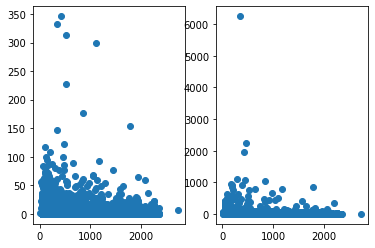

In [48]:
i = 1
for column in ['Pageloads_last_7_days','Clicks_last_7_days']:
    plt.subplot(1,2,i)
    plt.scatter(answer['User_Vintage'],answer[column])
    i +=1

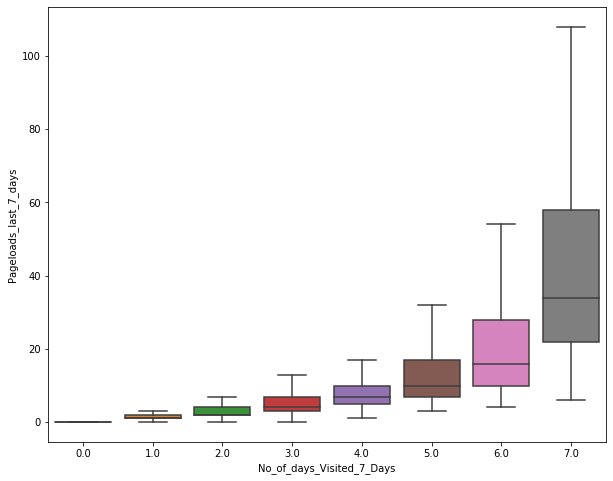

In [49]:
plt.figure(figsize=(10,8)) 
sns.boxplot(answer['No_of_days_Visited_7_Days'],answer['Pageloads_last_7_days'],showfliers=False)


### Let us see the grouped distribution of customers as per vintage

Text(0, 0.5, 'No Of Customers')

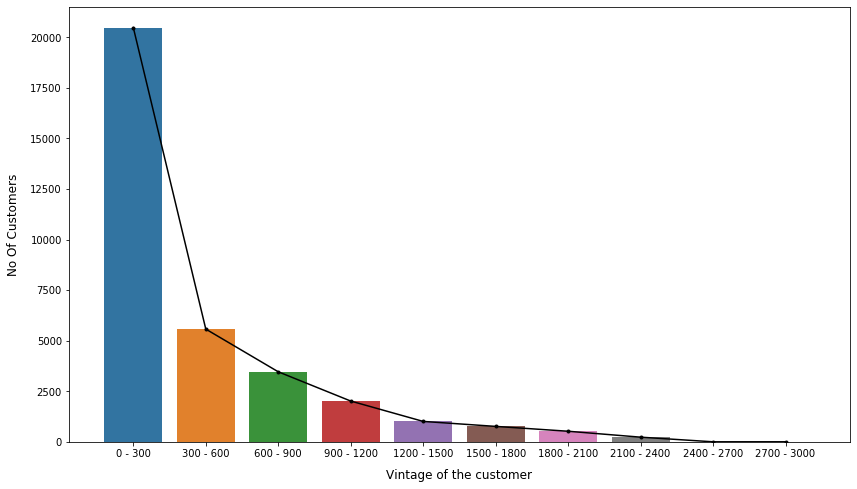

In [50]:
groups =  list(range(0,3300,300))


counts = []
labels = []
for i,group in enumerate(groups):
    if i == 10:
        break
    else:
        counts.append(answer[(answer['User_Vintage'] > groups[i]) & (answer['User_Vintage'] <= groups[i+1])].shape[0])
        labels.append(f'{group} - {groups[i+1]}')

        
        

plt.figure(figsize=(14,8))
sns.barplot(x = labels, y = counts)
plt.plot(labels,counts,'.-',c='black')
plt.xlabel("Vintage of the customer",fontdict = {"size":12},labelpad=10)
plt.ylabel("No Of Customers",fontdict = {"size":12},labelpad=10)

17054
23138 399.6161820851689


<function matplotlib.pyplot.show(*args, **kw)>

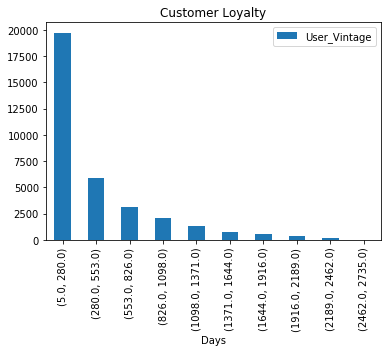

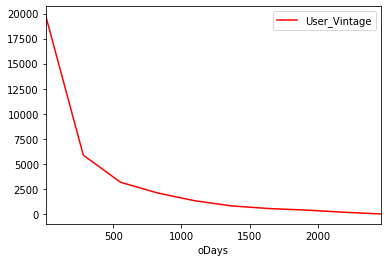

In [51]:
df1=answer['User_Vintage'].value_counts(bins=10) .reset_index().rename(columns={'index':'bin'})
df1['Days'] = [(np.floor(x.left), np.floor(x.right)) for x in df1['bin']]
Median_Users=answer[answer['User_Vintage'] <= answer['User_Vintage'].median()]
print(Median_Users['User_Vintage'].count())
mean_Users=answer[answer['User_Vintage'] <= answer['User_Vintage'].mean()]
print(mean_Users['User_Vintage'].count(),answer['User_Vintage'].mean())
df1.plot(kind = 'bar' ,x= 'Days',y='User_Vintage')
 
plt.title('Customer Loyalty')
plt.show
#Fixe for the Line Graphs
df1['oDays'] = [(np.floor(x.left)) for x in df1['bin']]
oPlot=df1.plot(kind = 'line' ,x= 'oDays',y='User_Vintage' ,color='red')

plt.show



## Let us see the influence of the Operating system to visits in 15 days

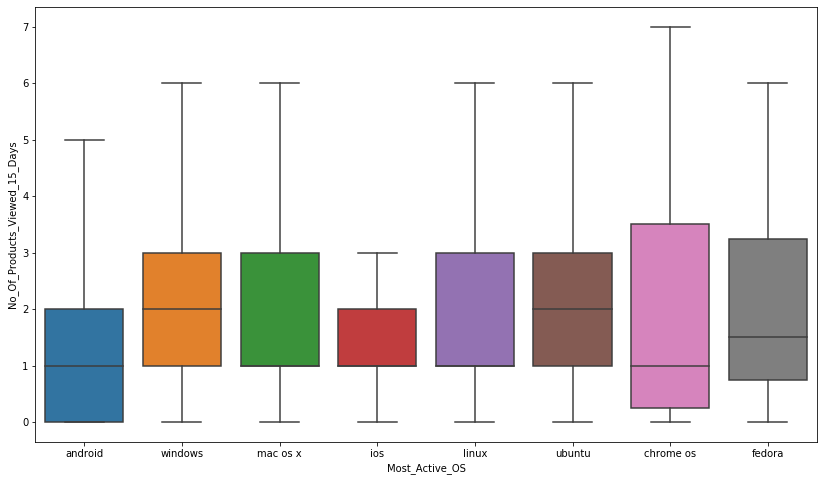

In [52]:
plt.figure(figsize=(14,8))
sns.boxplot(data = answer,x = 'Most_Active_OS',y = 'No_Of_Products_Viewed_15_Days',showfliers=False)

In [53]:
answer

,UserID,No_of_days_Visited_7_Days,No_Of_Products_Viewed_15_Days,User_Vintage,Most_Viewed_product_15_Days,Most_Active_OS,Recently_Viewed_Product,Pageloads_last_7_days,Clicks_last_7_days
0,U100002,0.0,2.0,53,Pr100258,android,Pr100258,0.0,0.0
1,U100003,1.0,3.0,1021,Pr100079,windows,Product101,1.0,2.0
2,U100004,1.0,16.0,341,Product101,windows,Product101,1.0,0.0
3,U100005,1.0,3.0,681,Pr100812,android,Pr100234,1.0,0.0
4,U100006,1.0,1.0,55,Pr101111,android,Pr101111,1.0,0.0
...,...,...,...,...,...,...,...,...,...
34045,U136960,0.0,0.0,755,Pr100172,windows,Pr100172,0.0,0.0
34046,U136961,0.0,0.0,60,Pr101381,android,Pr101381,0.0,0.0
34047,U136963,0.0,0.0,1420,Pr100102,android,Pr100166,0.0,0.0
34048,U136964,0.0,0.0,495,Pr100769,windows,Pr100769,0.0,0.0


In [54]:
answer['Most_Viewed_product_15_Days'].describe()

count        34050
unique        2035
top       Pr100017
freq          1747
Name: Most_Viewed_product_15_Days, dtype: object

In [55]:
answer.columns


Index(['UserID', 'No_of_days_Visited_7_Days', 'No_Of_Products_Viewed_15_Days',
       'User_Vintage', 'Most_Viewed_product_15_Days', 'Most_Active_OS',
       'Recently_Viewed_Product', 'Pageloads_last_7_days',
       'Clicks_last_7_days'],
      dtype='object')

In [56]:
answer['Most_Active_OS'].value_counts()

windows      20138
android       9748
mac os x      2426
linux          932
ios            485
ubuntu         295
chrome os       14
fedora          12
Name: Most_Active_OS, dtype: int64